# Debugging Amazon SageMaker training jobs in real time with Debugger

## Overview

Debugger is a new capability of Amazon SageMaker that allows debugging machine learning training. 
It lets you go beyond just looking at scalars like losses and accuracies during training and gives you full visibility into all tensors 'flowing through the graph' during training. Debugger helps you to monitor your training in near real time using rules and would provide you alerts, once it has detected inconsistency in training flow.

Using Debugger is a two step process: Saving tensors and Analysis. Let's look at each one of them closely.

### Saving tensors

Tensors define the state of the training job at any particular instant in its lifecycle. Debugger exposes a library which allows you to capture these tensors and save them for analysis.

### Analysis

There are two ways to get to tensors and run analysis on them. One way is to use concept called ***Rules***. For more information about a rules-based approach to analysis, see [Rules](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md#Rules). The focus of this notebook is on another way of analysis: **Manual**.

Manual analysis is what you use when there are no rules available to detect type of an issue you are running into and you need to get to raw tensors in order to understand what data is travelling through your model duing training and, hopefully, root cause a problem or two with your training job.

Manual analysis is powered by Debugger API - a framework that allows to retrieve tensors and scalas (e.g. debugging data) saved during training job via few lines of code. One of the most powerful features provided by it is real time access to data - you can get tensors and scalars ***while your training job is running***.

This example guides you through installing required components for emitting tensors in an Amazon SageMaker training job and using Debugger API to access those tensors while training is running. Use a small gluon CNN model and train it on the FashionMNIST dataset. While the job is running, you retrieve activations of the first convolutional layer from each of 100 batches and visualize them. Also we will visualize weights of that level after the job is done.

Before we proceed let us install the smdebug binary which allows us to perform interactive analysis in this notebook. After installing it, please restart the kernel, and when you come back skip this cell.

### Installing smdebug


In [1]:
!python -m pip install smdebug

  Using cached botocore-1.19.63-py2.py3-none-any.whl (7.2 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.19.9
    Uninstalling botocore-1.19.9:
      Successfully uninstalled botocore-1.19.9


## Training MXNet models in Amazon SageMaker with Debugger

Train a small MXNet CNN model with the FashonMNIST dataset in this notebook, with Debugger enabled. This is done using an Amazon SageMaker MXNet 1.6.0 container with script mode. Debugger currently works with Python3, so be sure to set `py_version='py3'` when creating the Amazon SageMaker Estimator.

First, train a simple training script mnist_gluon_realtime_visualize_demo.py with Debugger enabled in Amazon SageMaker using the Amazon SageMaker Estimator API. In this example, for simplicity sake, Debugger  captures all tensors as specified in its configuration every 100 steps (one step is one batch). While training job is running, use Debugger API to access saved tensors in real time and visualize them. Rely on Debugger to take care of downloading fresh set of tensors every time you query for them.

## Enable Debugger in Estimator object

Enabling Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```
sagemaker_simple_estimator = MXNet(...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="conv0_tensors",
                parameters={
                    "include_regex": "conv0.*",
                    "save_interval": "100"
                }
            )
        ]
    )
)
```
Consider this almost "magical" config object. Its purpose is to instruct Estimator (and CreateTrainingJob API method that is called) with what debugging data you are interested in for the debugging and visualization exercise. Here are two parameters: 
- `s3_output_path`: it points to S3 bucket where you intend to store the debugging tensors. The amount of data saved depends on multiple factors. Major ones are training job, dataset, model, and frequency of saving tensors. This bucket should be in your AWS account and you have full access control over it. **Important**: This S3 bucket should be originally created in the same Region where your training job will be running, otherwise you might run into problems with cross-Region access.
- `collection_configs` enumerates named collections of tensors to save. Collections are a convenient way to organize relevant tensors under same umbrella to make it easy to navigate them during analysis. In this particular case create a single collection with name 'conv0_tensors' and ask it to save all tensors whose name matches 'conv0.\*' regex. You know this name based on the structure of the model defined in [model training script](./scripts/mnist_gluon_realtime_visualize_demo.py). You also instructed Debugger to save tensors every 100 steps, where one step is one batch during a training job. Also, see [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/API.md#collection) documentation for all parameters that are supported by Collections and DebuggerConfig

### Configuring the inputs for the training job

Now call the Amazon SageMaker MXNet Estimator to kick off a training job along with enabling Debugger functionality.

- `entry_point_script` points to the simple MXNet training script that is ran by training job
- `hyperparameters` are the parameters that will be passed to the training script
- `train_volume_size` with value *400* ensures enough EBS volume is provisioned to collect tensors emitted by the training job

In [2]:
%load_ext autoreload
%autoreload 2

import sagemaker
import boto3
import os
import sagemaker

from sagemaker.mxnet import MXNet
from sagemaker.debugger import rule_configs, DebuggerHookConfig, CollectionConfig
from smdebug.mxnet import modes

sagemaker_session = sagemaker.Session()

entry_point_script = "./scripts/mnist_gluon_realtime_visualize_demo.py"
hyperparameters = {"batch-size": 256, "learning_rate": 0.1, "epochs": 10}
base_job_name = "mxnet-realtime-analysis-example"

# Make sure to set this to your bucket and location
BUCKET_NAME = sagemaker_session.default_bucket()
LOCATION_IN_BUCKET = "smdebug-real-time-demo"

s3_bucket_for_tensors = "s3://{BUCKET_NAME}/{LOCATION_IN_BUCKET}".format(
    BUCKET_NAME=BUCKET_NAME, LOCATION_IN_BUCKET=LOCATION_IN_BUCKET
)

[2021-06-08 19:08:25.654 ip-172-31-33-148:7221 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [6]:
sagemaker_simple_estimator = MXNet(
    role=sagemaker.get_execution_role(),
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    volume_size=400,
    entry_point=entry_point_script,
    hyperparameters=hyperparameters,
    framework_version="1.6.0",
    py_version="py3",
    max_run=3600,
    sagemaker_session=sagemaker_session,
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=s3_bucket_for_tensors,  # Required
        collection_configs=[
            CollectionConfig(
                name="conv0_tensors",
                parameters={"include_regex": "conv0.*", "save_interval": "100"},
            )
        ],
    ),
)

With the next step, start a training job using the Estimator object you created above. This job is started in an asynchronous, non-blocking way. This means that control is passed back to notebook and further commands are run while training job is progressing.

In [7]:
# This is a fire and forget event. By setting wait=False, we just submit the job to run in the background.
# SageMaker will spin off one training job and release control to next cells in the notebook.
# Please follow this notebook to see status of the training job.
sagemaker_simple_estimator.fit(wait=True)

2021-06-08 19:09:41 Starting - Starting the training job...
2021-06-08 19:09:43 Starting - Launching requested ML instances......
2021-06-08 19:10:52 Starting - Preparing the instances for training......
2021-06-08 19:12:06 Downloading - Downloading input data
2021-06-08 19:12:06 Training - Downloading the training image..2021-06-08 19:12:21,995 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-06-08 19:12:21,998 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-06-08 19:12:22,016 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":256,"epochs":10,"learning_rate":0.1}', 'SM_USER_ENTRY_POINT': 'mnist_gluon_realtime_visualize_demo.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{}', 'SM_O


### Result

As a result of the above command, Amazon SageMaker starts one training job for you and it produces the tensors to be analyzed. This job runs in a background without you having to wait for it to complete in order to continue with the rest of the notebook. Because of this asynchronous nature of the training job, monitor its status so that you don't start to request debugging tensors too early. Tensors are only produced during training phase of the Amazon SageMaker training job, so wait until that begins.

## Analysis and Visualization

### Checking on the training job status

Check the status of the training job by running the following code. It checks on the status of an Amazon SageMaker training job every 15 seconds. After a job has started its training cycle, control is released to the next cells in the notebook. That means a training job started to tune the model and, in parallel, emit debugging tensors.

In [8]:
# some helper method first, to render status status updates
import time
import sys
from time import gmtime, strftime


def print_same_line(s):
    sys.stdout.write("\r{}: {}".format(strftime("%X", gmtime()), s))
    sys.stdout.flush()


# Below command will give the status of training job
# Note: In the output of below command you will see DebugConfig parameter
# which describes what, where and how debugging data is to be collected
job_name = sagemaker_simple_estimator.latest_training_job.name
print("Training job name: " + job_name)

client = sagemaker_simple_estimator.sagemaker_session.sagemaker_client

description = client.describe_training_job(TrainingJobName=job_name)

if description["TrainingJobStatus"] != "Completed":
    while description["SecondaryStatus"] not in {"Training", "Completed"}:
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description["TrainingJobStatus"]
        secondary_status = description["SecondaryStatus"]
        print_same_line(
            "Current job status: [PrimaryStatus: {}, SecondaryStatus: {}]".format(
                primary_status, secondary_status
            )
        )
        time.sleep(15)

Training job name: mxnet-realtime-analysis-example-2021-06-08-19-09-41-105


### Retrieving and Analyzing tensors

Before getting to analysis, here are some notes on concepts being used in Debugger that help with analysis.
- ***Trial*** - object that is a center piece of Debugger API when it comes to getting access to tensors. It is a top level abstract that represents a single run of a training job. All tensors emitted by training job are associated with its *trial*.
- ***Step*** - object that represents next level of abstraction. In Debugger - *step* is a representation of a single batch of a training job. Each trial has multiple steps. Each tensor is associated with multiple steps - having a particular value at each of the steps.
- ***Tensor*** - object that represent actual *tensor* saved during training job. *Note* - it could be a scalar as well (for example, losses are saved as scalars).

For more details on aforementioned concepts as well as on Debugger API in general (including examples) please refer to [Debugger Analysis API](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md) documentation.

Below, you can find several methods to help with retrieving and plotting tensors. In *get_data* you use concepts described above to retrieve data. You can expect to get steps_range that has one or more steps (batches) for which you want to get tensors. Two other methods are helpers to plot tensors.

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def get_data(trial, tname, batch_index, steps_range, mode=modes.GLOBAL):
    tensor = trial.tensor(tname)
    vals = []
    for s in steps_range:
        val = tensor.value(step_num=s, mode=mode)[batch_index][0]
        vals.append(val)
    return vals


def create_plots(steps_range):
    fig, axs = plt.subplots(
        nrows=1,
        ncols=len(steps_range),
        constrained_layout=True,
        figsize=(2 * len(steps_range), 2),
        subplot_kw={"xticks": [], "yticks": []},
    )
    return fig, axs


def plot_tensors(trial, layer, batch_index, steps_range):
    if len(steps_range) > 0:
        fig, axs = create_plots(steps_range)
        vals = get_data(trial, layer, batch_index, steps_range)

        for ax, image, step in zip(
            axs.flat if isinstance(axs, np.ndarray) else np.array([axs]), vals, steps_range
        ):
            ax.imshow(image, cmap="gray")
            ax.set_title(str(step))
        plt.show()

Now that you are prepared with methods to get data and plot it, get to it. The goal of the next block is to instantiate a ***Trial***, a central access point for all Debugger API calls to get tensors. Do that by inspecting currently running training job and extracting necessary parameters from its debug config to instruct Debugger where the data you are looking for is located. Note:
- Tensors are being stored in your own S3 bucket to which you can navigate and manually inspect its content if desired.
- You might notice a slight delay before trial object is created. It is normal as Debugger will monitor corresponding bucket with tensors and wait until tensors appear in it. The delay is introduced by less than instantaneous upload of tensors from training container to your S3 bucket. 

In [10]:
import os
from urllib.parse import urlparse
from smdebug.trials import create_trial

# this is where we create a Trial object that allows access to saved tensors
trial = create_trial(sagemaker_simple_estimator.latest_job_debugger_artifacts_path())

[2021-06-08 19:24:48.685 ip-172-31-33-148:7221 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-688520471316/smdebug-real-time-demo/mxnet-realtime-analysis-example-2021-06-08-19-09-41-105/debug-output


Using the next command you can conveniently inspect all tensors that are produced by a model and saved by Debugger. You can do that easily because you put them under the umbrella of one single collection.

In [11]:
# inspect tensors saved in conv0_tensors collection (for conv0 layer of our model)
trial.tensor_names(collection="conv0_tensors")

[2021-06-08 19:24:51.226 ip-172-31-33-148:7221 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-06-08 19:24:52.247 ip-172-31-33-148:7221 INFO trial.py:210] Loaded all steps


['conv0_bias',
 'conv0_input_0',
 'conv0_output_0',
 'conv0_relu_input_0',
 'conv0_relu_output_0',
 'conv0_weight',
 'gradient/conv0_bias',
 'gradient/conv0_weight']

### Visualize tensors of a running training job
Below you wait until Debugger has downloaded initial chunk of tensors to look at. Once that first chunk is ready, you get new chunks every 5 seconds, and can plot their tensors correspondingly one under another.

19:25:10: Waiting for tensors to become available...
Done
Getting tensors and plotting...


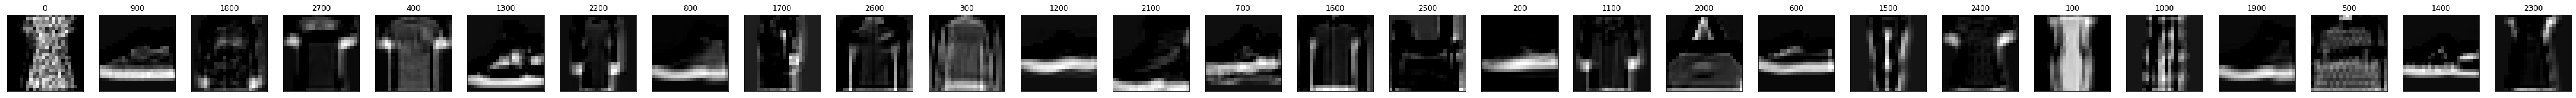


Done


In [12]:
# Below we select the very first tensor from every batch.
# Feel free to modify this and select another tensor from the batch.
batch_index = 0

# This is a name of a tensor to retrieve data of.
# Variable is called `layer` as this tensor happens to be output of first convolutional layer.
layer = "conv0_output_0"

steps = 0
while steps == 0:
    # trial.steps return all steps that have been downloaded by Debugger to date.
    # It doesn't represent all steps that are to be available once training job is complete -
    # it is a snapshot of a current state of the training job. If you call it after training job is done
    # you will get all tensors available at once.
    steps = trial.steps()
    print_same_line("Waiting for tensors to become available...")
    time.sleep(5)
print("\nDone")

print("Getting tensors and plotting...")
rendered_steps = []

# trial.loaded_all_steps is a way to keep monitoring for a state of a training job as seen by Debugger.
# When SageMaker completes training job Debugger, and trial, becomes aware of it.

loaded_all_steps = False
while not loaded_all_steps:
    loaded_all_steps = trial.loaded_all_steps
    steps = trial.steps()
    # quick way to get diff between two lists
    steps_to_render = list(set(steps).symmetric_difference(set(rendered_steps)))
    # plot only tensors from newer chunk
    plot_tensors(trial, layer, batch_index, steps_to_render)
    rendered_steps.extend(steps_to_render)
    time.sleep(5)
print("\nDone")

### Additional visualizations

Now that you completed plotting tensors showing output of first layer of the model during training job run, plot more tensors! This time you get all of them at once as a training job has finished and Debugger is aware of all tensors emitted by it. You can visualize tensors representing weights of first convolutional layer (e.g., its kernels). By inspecting each row of plotted tensors from left to right you can notice progression in how each kernel was "learning" its values. You will most likely notice that most changes in kernels are happening closer to the first steps of training. Closer toward finish of training job updates to kernels become less and less noticeable. This suggests training job is converging. *Note*: convergence doesn't necessarily mean increase in accuracy but it often accommodates that.

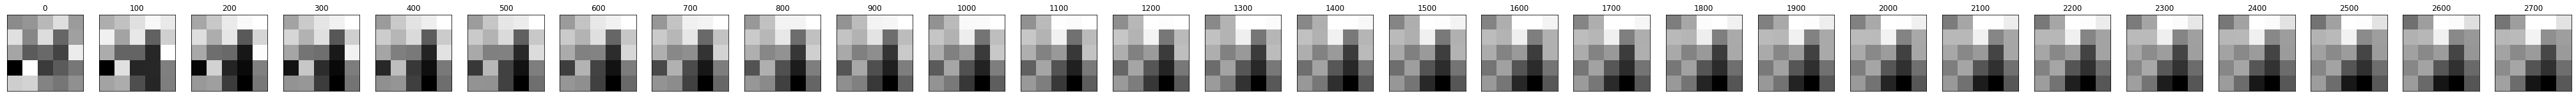

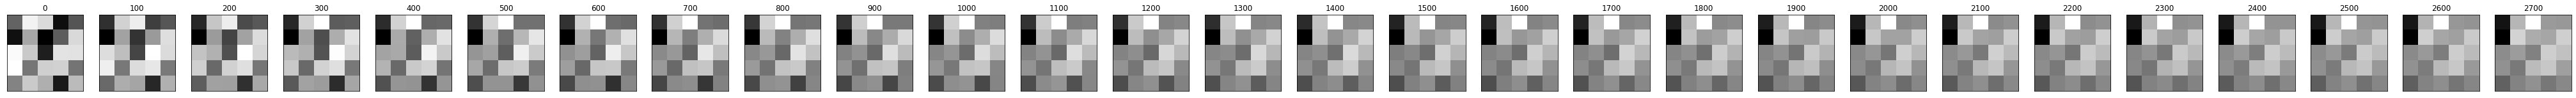

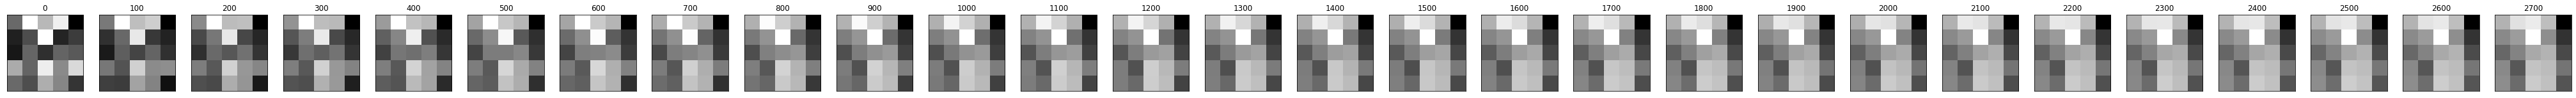

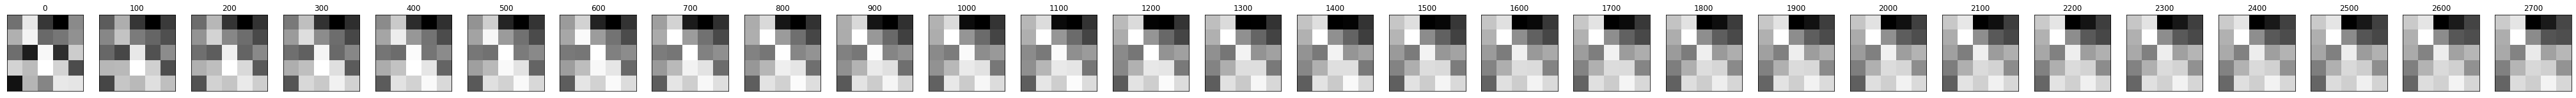

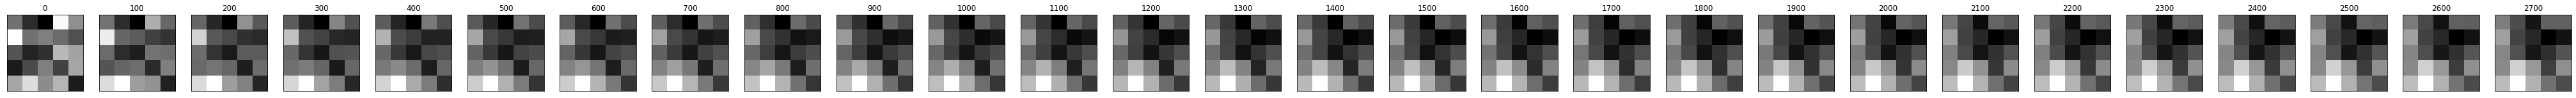

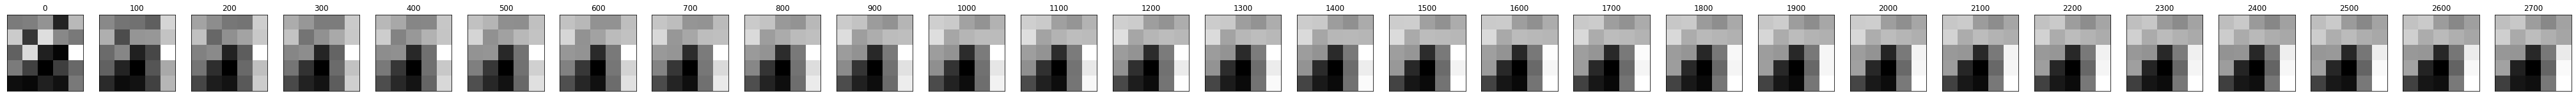

In [13]:
# Let's visualize weights of the first convolutional layer as they progressively change through training.
layer = "conv0_weight"

steps = trial.tensor(layer).steps()
for i in range(0, trial.tensor(layer).value(step_num=steps[0]).shape[0]):
    plot_tensors(trial, layer, i, trial.tensor(layer).steps())

For additional example of working with debugging tensors and visualizing them please feel free to try it out at [MNIST tensor plot](../mnist-tensor-plot/mnist-tensor-plot.ipynb) example.